In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [59]:
def plot(name, ax=None, **kwargs):
    data = pd.read_csv(f'../data/{name}.csv', names=['duration', 'score'])

    if ax is None:
        fig, ax = plt.subplots() 
        data.plot.scatter('duration', 'score', ax=ax, alpha=0.25, c='gray')
    data.duration = pd.to_timedelta(data.duration, 'ms')
    rolling_scores = data.set_index('duration').sort_index().score.rolling('750ms', center=True).mean()
    
    rolling_scores = rolling_scores.to_frame().reset_index()
    rolling_scores.duration = rolling_scores.duration.dt.total_seconds() * 1000
    
    
    ax.plot(rolling_scores.duration, rolling_scores.score, **kwargs)
    #plt.figtext(0.5, 0.25, 'The model improves with\nmore search time, but\nquickly plateaus at\naround 2000 ms.', fontsize=10)
    
    plt.title('Model score given duration in ms')
    plt.ylim((0, 60))
    plt.xlim((0, 4000))
    
    ax

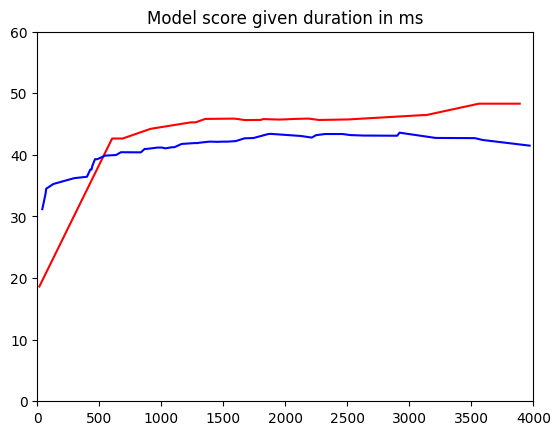

In [60]:
fig, ax = plt.subplots() 
plot('prune-600-', ax=ax, c='red')
plot('test', ax=ax, c='blue')